<h1><center>Santander Customer Satisfaction - Baseline model</center></h1>

In this notebook we will be exploring the problem statement of predicting the dissatisfied customers of Santander. This is a competition that was held at Kaggle and the [data](https://www.kaggle.com/c/santander-customer-satisfaction/) can be downloaded after accepting the rules. 

The purpose of this notebook is to demonstrate the ML techniques to solve such structured problems.

In [ ]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [44]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import operator
import xgboost as xgb
from collections import defaultdict
import numpy as np
from sklearn.utils import shuffle
from src.data.clean_dataset import feats_n_unique
from dotenv import find_dotenv, load_dotenv
from sklearn.decomposition import PCA
from sklearn.preprocessing import Normalizer
from src.data.clean_dataset import remove_new_values
from src.features.pruning.interaction import get_correlated_features
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import chi2, f_classif, mutual_info_classif
from sklearn.feature_selection import GenericUnivariateSelect

PROJECT_PATH = '../../'

## Loading the raw data files

In [16]:
train = pd.read_csv(os.path.join(PROJECT_PATH, "data", "raw", "train.csv"))

test = pd.read_csv(os.path.join(PROJECT_PATH, "data", "raw", "test.csv"))

In [45]:
train_x = train.drop(['TARGET'], axis=1)
train_y = train['TARGET']

## 1. Data Cleaning

### 1.1. Limiting the test values to max-min from train

In [30]:
test = remove_new_values(train_x, test)

## 2. Feature Transform

1. Log of certain features
2. Converting categorical to one-hot
3. Missing value imputation

### 2.1 [FAILED] Log of highly varied features

Attempted log transformation of highly varied features
- didn't see an improvement in auc
- infact there was a drop in auc by 0.005 when trained using xgb
- hence, ignore this step

In [32]:
def log_transform(train, test):
    train_describe = train.describe()

    train_var = ((train_describe.loc['max'] - train_describe.loc['50%']))

    features_log_transform = train_var.index[train_var>1e6]

    train_transform = train.copy()

    for c in features_log_transform:
        min_val = train_transform[c].min()
        add_val = 0
        if min_val < 0.01:
            add_val = 0.01 - min_val
        train_transform[c] = np.log(train_transform[c] + add_val)
    
    
    test_transform = test.copy()

    for c in features_log_transform:
        min_val = test_transform[c].min()
        add_val = 0
        if min_val < 0.01:
            add_val = 0.01 - min_val
        test_transform[c] = np.log(test_transform[c] + add_val)
        
    return train_transform, test_transform


# train_transform, test_transform = log_transform(train, test)

## 3. Feature Pruning

1. Delete features with no variance 
2. Delete highly correlated features
3. Get feature selection (importances or scikit) and delete one-by-one
4. Transform and delete

### 3.1 Removing columns with only 1 unique value

If a feature has only 1 unique value then there contains no information in predicting our target variable.

In [20]:
# removing features with only one unique value

train_unique_feats = feats_n_unique(train, 1)
train.drop(columns=train_unique_feats, inplace=True)

test.drop(columns=train_unique_feats, inplace=True)

### 3.2 Removing correlated features

In [23]:
feats_corr_del = get_correlated_features(train_x, 0.98)

### 3.3 Removing features based on model importances

In [49]:
model = xgb.XGBClassifier(learning_rate=0.02, subsample=0.7, colsample_bytree=0.6)
bst_model = model.fit(train_x, train_y)

feature_model = pd.DataFrame([train_x.columns, bst_model.feature_importances_]).T

feature_model.sort_values([1], ascending=False)

feature_selected_model = feature_model[feature_model[1]>=0.001][0].values

In [ ]:
sorted_thresholds = np.sort(feature_model[1].unique())

for thresh in sorted_thresholds:
    select_from_model = SelectFromModel(bst_model, threshold=thresh, prefit=True)
    train_x_subset = select_from_model.transform(train_x)
    
    xgb_classifier = xgb.XGBClassifier(learning_rate=0.02, nthread=4, colsample_bytree=0.6, subsample=0.7)
    xgb_model = xgb_classifier.fit(train_x_subset, train_y)
    
    preds = xgb_model.predict_proba(train_x_subset)
    auc_score = roc_auc_score(train_y.values, preds[:, 1])
    print ("Thresh {0} number of features {1} auc score {2}".format(thresh, train_x_subset.shape[1], auc_score))

### 3.4 Removing features based on statistical tests

In [52]:
feature_stat = GenericUnivariateSelect(mutual_info_classif, mode='k_best', param=60)
feature_stat.fit(train_x.to_numpy(), train_y)
feature_selected_stat = train_x.columns[feature_stat.get_support()]

In [59]:
len(set(feature_selected_stat) & set(feature_selected_model))/len(feature_selected_model)

0.41509433962264153

## 4 Feature generation

1. Add PCA features
2. Add missing feature to indicate missing elements
3. Add number of zeros in each row
4. Perform EDA

### 4.1 Perform PCA with normalizer

In [36]:
normalizer = Normalizer()
pca = PCA(n_components=10)

In [43]:
pca_train = pca.fit_transform(normalizer.fit_transform(train.drop(['TARGET'], axis=1)))[:, :3]
train["pca_1"] = pca_train[:, 0]
train["pca_2"] = pca_train[:, 1]
train["pca_3"] = pca_train[:, 2]

pca_test = pca.transform(normalizer.transform(test))[:, :3]
test["pca_1"] = pca_test[:, 0]
test["pca_2"] = pca_test[:, 1]
test["pca_3"] = pca_test[:, 2]

### 4.2 Adding n_zeros per row

In [62]:
# adding zeros per row
train_x["n_zeros"] = (train_x==0).sum(axis=1)
test["n_zeros"] = (test==0).sum(axis=1)

## 5. Validation setup

In [64]:
skf = StratifiedKFold(n_splits=15, random_state=22)

## 6. Modeling

Here, an XGBoost model is tried from using the XGBoost library (not the scikit wrapper)

In [65]:
# xgb params
param = {'max_depth': 3, 'eta': 0.1, 'silent': 1, 'objective': 'binary:logistic'}
param['nthread'] = 4
param['eval_metric'] = 'auc'
param['colsample_bytree'] = 0.7

In [67]:
test_x = xgb.DMatrix(test)
full_train_x = xgb.DMatrix(train_x)


test_preds = None
train_preds = None

count = 0
for train_index, val_index in skf.split(train_x, train_y):
    x_train, x_val = train_x.iloc[train_index], train_x.iloc[val_index]
    y_train, y_val = train_y.iloc[train_index], train_y.iloc[val_index]
    
    dtrain = xgb.DMatrix(x_train, label=y_train) 
    dval = xgb.DMatrix(x_val, label=y_val)
    evallist = [(dval, 'eval'), (dtrain, 'train')]
    
    num_round = 130
    bst = xgb.train(param, dtrain, num_round, evallist)
    
    pred_test = bst.predict(test_x)
    
    if test_preds is None:
        test_preds = pred_test
    else:
        test_preds *= pred_test
        
    pred_train = bst.predict(full_train_x)
    if train_preds is None:
        train_preds = pred_train
    else:
        train_preds *= pred_train

        
    count += 1


test_preds = test_preds ** (1.0/count)
train_preds = train_preds ** (1.0/count)

/Users/santoshgsk/Desktop/Code/venv/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[0]	eval-auc:0.796567	train-auc:0.783594
[1]	eval-auc:0.815082	train-auc:0.806321
[2]	eval-auc:0.439038	train-auc:0.798361
[3]	eval-auc:0.43954	train-auc:0.811631
[4]	eval-auc:0.445592	train-auc:0.814064
[5]	eval-auc:0.440356	train-auc:0.808746
[6]	eval-auc:0.446221	train-auc:0.818713
[7]	eval-auc:0.448168	train-auc:0.820403
[8]	eval-auc:0.354515	train-auc:0.820506
[9]	eval-auc:0.355654	train-auc:0.82061
[10]	eval-auc:0.353308	train-auc:0.819843
[11]	eval-auc:0.398303	train-auc:0.820444
[12]	eval-auc:0.403404	train-auc:0.821059
[13]	eval-auc:0.404246	train-auc:0.821849
[14]	eval-auc:0.407984	train-auc:0.818047
[15]	eval-auc:0.448242	train-auc:0.823811
[16]	eval-auc:0.415098	train-auc:0.817889
[17]	eval-auc:0.414967	train-auc:0.81671
[18]	eval-auc:0.414145	train-auc:0.817602
[19]	eval-auc:0.419135	train-auc:0.81658
[20]	eval-auc:0.460139	train-auc:0.819283
[21]	eval-auc:0.473914	train-auc:0.820152
[22]	eval-auc:0.534573	train-auc:0.819779
[23]	eval-auc:0.663388	train-auc:0.823654
[24]	e

[67]	eval-auc:0.819124	train-auc:0.851155
[68]	eval-auc:0.819441	train-auc:0.851455
[69]	eval-auc:0.819844	train-auc:0.851671
[70]	eval-auc:0.819547	train-auc:0.851813
[71]	eval-auc:0.819463	train-auc:0.852184
[72]	eval-auc:0.819098	train-auc:0.852545
[73]	eval-auc:0.819164	train-auc:0.852768
[74]	eval-auc:0.819168	train-auc:0.85295
[75]	eval-auc:0.819167	train-auc:0.853285
[76]	eval-auc:0.819479	train-auc:0.853508
[77]	eval-auc:0.819552	train-auc:0.853671
[78]	eval-auc:0.819436	train-auc:0.853778
[79]	eval-auc:0.819737	train-auc:0.853994
[80]	eval-auc:0.820287	train-auc:0.854104
[81]	eval-auc:0.820123	train-auc:0.854274
[82]	eval-auc:0.820203	train-auc:0.85465
[83]	eval-auc:0.820365	train-auc:0.854742
[84]	eval-auc:0.820614	train-auc:0.854883
[85]	eval-auc:0.820807	train-auc:0.85514
[86]	eval-auc:0.820987	train-auc:0.855249
[87]	eval-auc:0.821187	train-auc:0.855369
[88]	eval-auc:0.821189	train-auc:0.855514
[89]	eval-auc:0.821639	train-auc:0.855729
[90]	eval-auc:0.821953	train-auc:0.85

[2]	eval-auc:0.760899	train-auc:0.804288
[3]	eval-auc:0.763304	train-auc:0.815665
[4]	eval-auc:0.770681	train-auc:0.820346
[5]	eval-auc:0.77131	train-auc:0.814844
[6]	eval-auc:0.77651	train-auc:0.820943
[7]	eval-auc:0.777821	train-auc:0.822046
[8]	eval-auc:0.783244	train-auc:0.824243
[9]	eval-auc:0.789124	train-auc:0.826537
[10]	eval-auc:0.78802	train-auc:0.825042
[11]	eval-auc:0.785641	train-auc:0.825773
[12]	eval-auc:0.786028	train-auc:0.826878
[13]	eval-auc:0.785261	train-auc:0.825135
[14]	eval-auc:0.784064	train-auc:0.820308
[15]	eval-auc:0.787508	train-auc:0.826983
[16]	eval-auc:0.785572	train-auc:0.822682
[17]	eval-auc:0.781725	train-auc:0.820857
[18]	eval-auc:0.781587	train-auc:0.82036
[19]	eval-auc:0.779201	train-auc:0.818964
[20]	eval-auc:0.783104	train-auc:0.823421
[21]	eval-auc:0.783151	train-auc:0.823666
[22]	eval-auc:0.781658	train-auc:0.822554
[23]	eval-auc:0.785075	train-auc:0.826026
[24]	eval-auc:0.789356	train-auc:0.828814
[25]	eval-auc:0.789179	train-auc:0.832197
[26]

[68]	eval-auc:0.854372	train-auc:0.849202
[69]	eval-auc:0.854351	train-auc:0.849427
[70]	eval-auc:0.854428	train-auc:0.849549
[71]	eval-auc:0.854826	train-auc:0.849809
[72]	eval-auc:0.85487	train-auc:0.850276
[73]	eval-auc:0.854947	train-auc:0.850474
[74]	eval-auc:0.855063	train-auc:0.85078
[75]	eval-auc:0.855248	train-auc:0.850853
[76]	eval-auc:0.855525	train-auc:0.851083
[77]	eval-auc:0.855154	train-auc:0.851281
[78]	eval-auc:0.855009	train-auc:0.851426
[79]	eval-auc:0.855267	train-auc:0.851673
[80]	eval-auc:0.854901	train-auc:0.851769
[81]	eval-auc:0.854892	train-auc:0.851933
[82]	eval-auc:0.854692	train-auc:0.852099
[83]	eval-auc:0.854708	train-auc:0.852217
[84]	eval-auc:0.854629	train-auc:0.852363
[85]	eval-auc:0.854701	train-auc:0.852595
[86]	eval-auc:0.854717	train-auc:0.852874
[87]	eval-auc:0.854696	train-auc:0.852991
[88]	eval-auc:0.825286	train-auc:0.854462
[89]	eval-auc:0.82542	train-auc:0.854566
[90]	eval-auc:0.825702	train-auc:0.854887
[91]	eval-auc:0.825467	train-auc:0.85

[4]	eval-auc:0.82592	train-auc:0.819005
[5]	eval-auc:0.820991	train-auc:0.81396
[6]	eval-auc:0.825806	train-auc:0.823481
[7]	eval-auc:0.828102	train-auc:0.824577
[8]	eval-auc:0.829686	train-auc:0.827384
[9]	eval-auc:0.828975	train-auc:0.828047
[10]	eval-auc:0.828702	train-auc:0.826828
[11]	eval-auc:0.829185	train-auc:0.827614
[12]	eval-auc:0.828946	train-auc:0.828473
[13]	eval-auc:0.828272	train-auc:0.827344
[14]	eval-auc:0.824924	train-auc:0.820292
[15]	eval-auc:0.828444	train-auc:0.826467
[16]	eval-auc:0.825995	train-auc:0.822034
[17]	eval-auc:0.824828	train-auc:0.819832
[18]	eval-auc:0.824801	train-auc:0.820262
[19]	eval-auc:0.823807	train-auc:0.819373
[20]	eval-auc:0.827109	train-auc:0.822393
[21]	eval-auc:0.827703	train-auc:0.822865
[22]	eval-auc:0.826625	train-auc:0.821606
[23]	eval-auc:0.82849	train-auc:0.824372
[24]	eval-auc:0.832303	train-auc:0.828339
[25]	eval-auc:0.833898	train-auc:0.831562
[26]	eval-auc:0.834904	train-auc:0.832634
[27]	eval-auc:0.835597	train-auc:0.83449
[2

[70]	eval-auc:0.852562	train-auc:0.850055
[71]	eval-auc:0.852672	train-auc:0.850316
[72]	eval-auc:0.853281	train-auc:0.850531
[73]	eval-auc:0.853563	train-auc:0.850698
[74]	eval-auc:0.853499	train-auc:0.850784
[75]	eval-auc:0.853679	train-auc:0.850906
[76]	eval-auc:0.853785	train-auc:0.851148
[77]	eval-auc:0.853729	train-auc:0.851276
[78]	eval-auc:0.853719	train-auc:0.851443
[79]	eval-auc:0.853754	train-auc:0.851562
[80]	eval-auc:0.853795	train-auc:0.851768
[81]	eval-auc:0.853904	train-auc:0.852025
[82]	eval-auc:0.854118	train-auc:0.852286
[83]	eval-auc:0.854357	train-auc:0.852467
[84]	eval-auc:0.854454	train-auc:0.852628
[85]	eval-auc:0.854479	train-auc:0.852787
[86]	eval-auc:0.854279	train-auc:0.852949
[87]	eval-auc:0.854415	train-auc:0.853162
[88]	eval-auc:0.852283	train-auc:0.853577
[89]	eval-auc:0.852275	train-auc:0.85367
[90]	eval-auc:0.852308	train-auc:0.853836
[91]	eval-auc:0.852491	train-auc:0.85398
[92]	eval-auc:0.85241	train-auc:0.854094
[93]	eval-auc:0.852431	train-auc:0.85

[6]	eval-auc:0.811359	train-auc:0.818736
[7]	eval-auc:0.811336	train-auc:0.820959
[8]	eval-auc:0.816942	train-auc:0.82426
[9]	eval-auc:0.820494	train-auc:0.825874
[10]	eval-auc:0.819803	train-auc:0.823703
[11]	eval-auc:0.819713	train-auc:0.824417
[12]	eval-auc:0.819548	train-auc:0.825426
[13]	eval-auc:0.82206	train-auc:0.824524
[14]	eval-auc:0.812892	train-auc:0.819166
[15]	eval-auc:0.817999	train-auc:0.82336
[16]	eval-auc:0.816041	train-auc:0.82082
[17]	eval-auc:0.813072	train-auc:0.818646
[18]	eval-auc:0.813608	train-auc:0.817758
[19]	eval-auc:0.8137	train-auc:0.81616
[20]	eval-auc:0.815525	train-auc:0.81982
[21]	eval-auc:0.816717	train-auc:0.82066
[22]	eval-auc:0.815115	train-auc:0.819253
[23]	eval-auc:0.817554	train-auc:0.822765
[24]	eval-auc:0.8197	train-auc:0.825495
[25]	eval-auc:0.822345	train-auc:0.829223
[26]	eval-auc:0.824628	train-auc:0.831385
[27]	eval-auc:0.826631	train-auc:0.832614
[28]	eval-auc:0.826083	train-auc:0.831989
[29]	eval-auc:0.826947	train-auc:0.833461
[30]	ev

[73]	eval-auc:0.867797	train-auc:0.850157
[74]	eval-auc:0.867935	train-auc:0.850283
[75]	eval-auc:0.86783	train-auc:0.850658
[76]	eval-auc:0.867871	train-auc:0.850822
[77]	eval-auc:0.867706	train-auc:0.851055
[78]	eval-auc:0.86789	train-auc:0.85125
[79]	eval-auc:0.868023	train-auc:0.851594
[80]	eval-auc:0.868103	train-auc:0.851752
[81]	eval-auc:0.868075	train-auc:0.852024
[82]	eval-auc:0.868149	train-auc:0.852138
[83]	eval-auc:0.868197	train-auc:0.852326
[84]	eval-auc:0.868229	train-auc:0.852468
[85]	eval-auc:0.868407	train-auc:0.852708
[86]	eval-auc:0.868137	train-auc:0.852937
[87]	eval-auc:0.867974	train-auc:0.853161
[88]	eval-auc:0.867896	train-auc:0.853342
[89]	eval-auc:0.867903	train-auc:0.853469
[90]	eval-auc:0.867916	train-auc:0.853602
[91]	eval-auc:0.867755	train-auc:0.853716
[92]	eval-auc:0.867613	train-auc:0.853805
[93]	eval-auc:0.867441	train-auc:0.854036
[94]	eval-auc:0.867364	train-auc:0.854195
[95]	eval-auc:0.867414	train-auc:0.854272
[96]	eval-auc:0.867331	train-auc:0.85

[8]	eval-auc:0.834595	train-auc:0.823666
[9]	eval-auc:0.835204	train-auc:0.824206
[10]	eval-auc:0.834815	train-auc:0.823154
[11]	eval-auc:0.834808	train-auc:0.823536
[12]	eval-auc:0.836527	train-auc:0.824536
[13]	eval-auc:0.838026	train-auc:0.823456
[14]	eval-auc:0.833247	train-auc:0.817865
[15]	eval-auc:0.838052	train-auc:0.823516
[16]	eval-auc:0.833949	train-auc:0.819752
[17]	eval-auc:0.834687	train-auc:0.817935
[18]	eval-auc:0.834354	train-auc:0.817493
[19]	eval-auc:0.833009	train-auc:0.817255
[20]	eval-auc:0.836064	train-auc:0.821454
[21]	eval-auc:0.836586	train-auc:0.821485
[22]	eval-auc:0.836615	train-auc:0.820489
[23]	eval-auc:0.837869	train-auc:0.822997
[24]	eval-auc:0.837679	train-auc:0.825475
[25]	eval-auc:0.842161	train-auc:0.829689
[26]	eval-auc:0.844626	train-auc:0.830999
[27]	eval-auc:0.844978	train-auc:0.831844
[28]	eval-auc:0.843872	train-auc:0.831364
[29]	eval-auc:0.845167	train-auc:0.832545
[30]	eval-auc:0.846859	train-auc:0.833318
[31]	eval-auc:0.848072	train-auc:0.8

[74]	eval-auc:0.830027	train-auc:0.851989
[75]	eval-auc:0.830438	train-auc:0.852118
[76]	eval-auc:0.83034	train-auc:0.852414
[77]	eval-auc:0.830479	train-auc:0.852559
[78]	eval-auc:0.830646	train-auc:0.852768
[79]	eval-auc:0.830728	train-auc:0.852925
[80]	eval-auc:0.830457	train-auc:0.853264
[81]	eval-auc:0.830497	train-auc:0.853425
[82]	eval-auc:0.830543	train-auc:0.853501
[83]	eval-auc:0.830882	train-auc:0.85367
[84]	eval-auc:0.83098	train-auc:0.853801
[85]	eval-auc:0.830967	train-auc:0.853966
[86]	eval-auc:0.831176	train-auc:0.854177
[87]	eval-auc:0.83104	train-auc:0.854303
[88]	eval-auc:0.830921	train-auc:0.854401
[89]	eval-auc:0.830803	train-auc:0.854635
[90]	eval-auc:0.830828	train-auc:0.854743
[91]	eval-auc:0.830863	train-auc:0.855005
[92]	eval-auc:0.830955	train-auc:0.855194
[93]	eval-auc:0.830938	train-auc:0.855374
[94]	eval-auc:0.831088	train-auc:0.855517
[95]	eval-auc:0.83108	train-auc:0.855631
[96]	eval-auc:0.831081	train-auc:0.855723
[97]	eval-auc:0.812538	train-auc:0.8565

In [68]:
roc_auc_score(train_y, train_preds)

0.8591471542749896

In [71]:
test["TARGET"] = test_preds
test[["ID", "TARGET"]].to_csv("test_preds_cv15_n130_xgb.csv", index=False)

## Scores

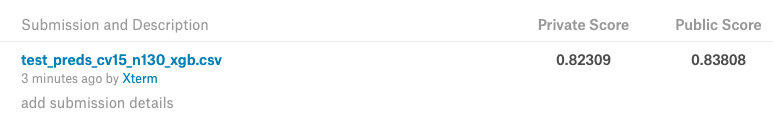

In [74]:
from IPython.display import display
from IPython.display import Image
img = Image("/Users/santoshgsk/Desktop/kaggle_score.png")
display(img)